In [1]:
# Module: Data Science in Finance, Machine Learning in 30 minutes!
# Version 2.0
# Topic : Building models
# Example source: https://www.kaggle.com/wendykan/lending-club-loan-data
#####################################################################
# For support or questions, contact Sri Krishnamurthy at
# sri@quantuniversity.com
# Copyright 2018 QuantUniversity LLC.
#####################################################################

# Building models

This notebook deals with understanding the lending data obtained from https://www.kaggle.com/wendykan/lending-club-loan-data. We will cluster the data using K-Means clustering to see patterns in the dataset.

# Contents

* Imports
* Exploring the data
    * Dataset
    * Numerical and Categorical Features
* Preparing the data
    * Normalizing the data
    * Randomizing the data
    * Train-Test split
* Metrics for Regression
    * RMSE
    * MAE
    * MAPE
* Machine Learning Models
    * Linear Regression
    * Random Forest
    * Neural Network Regressor
* Comparing model performance
* Making predictions
* Saving the model


## Imports

In [2]:
# for numerical analysis and data processing
import numpy as np
import pandas as pd
import itertools

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

# for Machine learning algorithms
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cdist

# for vizualizations
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Exploring the Data

## Dataset

The data set is the lending data for lendingclub from August 2011 to December 2011 for some borrowers. The feature descriptions for the data are also provided. Not all the features are required for making predictions, some features are redundant in the original data file. The provided data file is already cleaned and only relevant features are provided. There are two types of features, numerical and categorical.

Reading the input data from csv file.

In [3]:
df = pd.read_csv("../data/LendingClubLoan.csv", low_memory=False)
del df['issue_d'] # removing issue date as it wont affect the prediction (redundant feature)
df_description = pd.read_excel('../data/LCDataDictionary.xlsx').dropna()

## Numerical and Categorical features

In [4]:
numeric_columns = df.select_dtypes(include=['float64','int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    df[col] = df[col].astype('category')

In [5]:
numeric_columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'loan_status_Binary'],
      dtype='object')

In [6]:
categorical_columns

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'purpose', 'addr_state'],
      dtype='object')

In [7]:
p_categories = df['purpose'].cat.categories.tolist()
s_categories = df['addr_state'].cat.categories.tolist()
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.cat.codes)

Storing interest rate statistics which will be used later for inference. 

In [8]:
min_rate= df['int_rate'].min()
max_rate= df['int_rate'].max()
print(min_rate, max_rate, max_rate- min_rate)

5.42 24.11 18.689999999999998


# Preparing the dataset 

#### Normalizing the data
Normalize the data set for ease of calculations so that all features have values between 0 and 1.

In [22]:
df=(df-df.min())/(df.max()-df.min())

#### Randomizing the data
Randomize the dataset so that any ordered patterns dont influence the prediction. (We have already skipped date as an influencing factor)

In [23]:
df = df.iloc[np.random.permutation(len(df))]

#### Train-test split
The data is split into training and testing data. x represents the input features whereas y represents the output i.e. the interest rate.As a rule of thumb, we split the data into 80% training data and 20% testing or validation data.

In [24]:
y = df.iloc[:,df.columns.isin(["int_rate"])]
x = df.loc[:, ~df.columns.isin(["int_rate"])]

total_samples=len(df)
split = 0.8

x_train = x[0:int(total_samples*split)]
x_test = x[int(total_samples*split):total_samples]
y_train = y[0:int(total_samples*split)]
y_test = y[int(total_samples*split):total_samples]

In [25]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    Calculates mean absolute error of the true and predicted values.
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    count = 0
    sum = 0
    for a, p in zip(y_true, y_pred):
        if(a!=0):
            sum+=(abs(a-p)/a)
            count+=1
    return (sum/count) * 100

In [32]:
def view_metrics(y_test, predictions, algorithm, samples, total_samples):
    '''
    Plots the true and predicted values and prints RMS, MAE and MAPE metrics.
    '''
    fig = plt.figure(figsize=(18,5))
    plt.scatter(x=[i for i in range(samples)], y=[x for x in predictions[0:samples]], label='Predicted values')
    plt.scatter(x=[i for i in range(samples)], y=[x[0] for x in y_test.values[0:samples]], label='True values')
    plt.title('True and Predicted values for test dataset - %s' % algorithm)
    plt.legend()
    plt.show()
    
#     fig = plt.figure(figsize=(18,5))
#     plt.scatter(x=[i for i in range(total_samples)], y=[x for x in predictions], label='Predicted values')
#     plt.scatter(x=[i for i in range(total_samples)], y=[x[0] for x in y_test.values], label='True values')
#     plt.title('True and Predicted values for test dataset - %s' % algorithm)
#     plt.legend()
#     plt.show()

    RMS =  np.sqrt(mean_squared_error(y_test, predictions, multioutput='raw_values'))
    MAE = mean_absolute_error(y_test, predictions, multioutput='raw_values')
    MAPE = mean_absolute_percentage_error(y_test, predictions)
    print("Root Mean Squared Error:", RMS)
    print("Mean Absolute Error", MAE) 
    print("Mean Absolute Percentage Error", MAPE)
    return RMS, MAE, MAPE

### Metrics for regression models

#### Root Mean Squared Error
It represents the sample standard deviation of the differences between predicted values and observed values.

![alt text](rmse.PNG "Logo Title Text 1")

#### Mean Absolute Error
MAE is the average of the absolute difference between the predicted values and observed value. The MAE is a linear score which means that all the individual differences are weighted equally in the average.

![alt text](mae.PNG "Logo Title Text 1")

#### Mean Absolute Percent Error
MAPE measures the size of the error in percentage terms. It is calculated as the average of the unsigned percentage error.

![alt text](mape.PNG "Logo Title Text 1")

# Machine Learning Models

### Linear Regression

In [29]:
lin_reg_model = LinearRegression() # build model
lin_reg_model= lin_reg_model.fit(x_train, y_train) # train model
R2 = lin_reg_model.score(x_train, y_train) # coefficient of determination
print(lin_reg_model.coef_)

[[ 1.29568669e-02  1.00109210e-03 -2.66503799e-02 -5.96019368e-03
   1.08918313e+00  1.11147165e-03  7.01049404e-03 -4.85718597e-02
   2.47588314e-03 -7.77119923e-03 -7.27497458e-04  9.15157100e-03
   1.16803356e-02  3.26459785e-02 -1.26778896e-03]]


In [30]:
lin_reg_model_predictions = lin_reg_model.predict(x_test) # make predictions

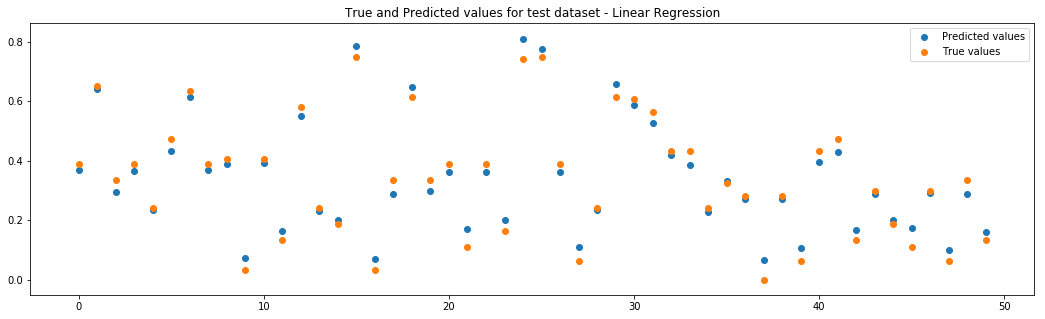

Root Mean Squared Error: [0.0377643]
Mean Absolute Error [0.03093095]
Mean Absolute Percentage Error [18.68575409]


In [33]:
lin_reg_model_metrics = view_metrics(y_test, lin_reg_model_predictions,'Linear Regression', samples = 50, total_samples=2000)
## If predicted value is same as true value, the points will be overlapping. Closer the points, better is the prediction.

### Random Forest Regressor Model

In [34]:
rand_forest_model = RandomForestRegressor(max_depth=5, random_state=0) # build model
rand_forest_model = rand_forest_model.fit(x_train, y_train.values.ravel()) # train model
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
feature_importance = rand_forest_model.feature_importances_
R2 = rand_forest_model.score(x_train, y_train) # coefficient of determination
rand_forest_model_predictions = rand_forest_model.predict(x_test) # make predictions

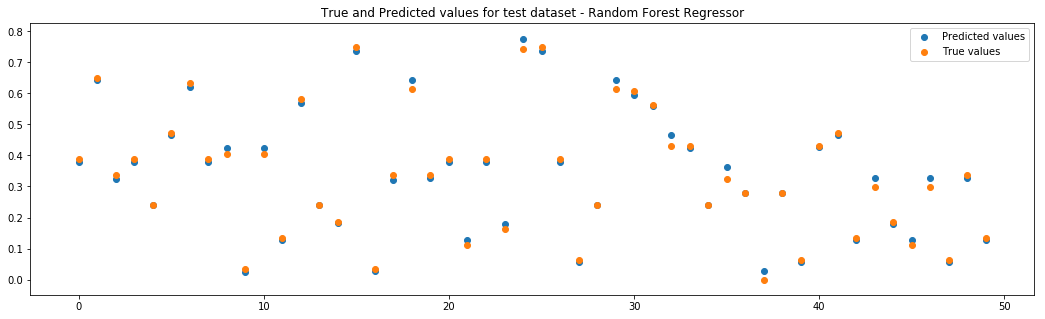

Root Mean Squared Error: [0.01659546]
Mean Absolute Error [0.01149154]
Mean Absolute Percentage Error [5.85840958]


In [35]:
rand_forest_model_metrics = view_metrics(y_test, rand_forest_model_predictions,'Random Forest Regressor', samples = 50, total_samples=2000)

### Neural Network Regression Model

In [36]:
nn_model = MLPRegressor(hidden_layer_sizes=(10,4),
                                    activation='relu', # activation function in the nodes of the neral net
                                    solver='adam', # optimizer algorithm
                                    learning_rate='constant',
                                    learning_rate_init=0.001, # initial learning rate
                                    max_iter=300, # max iterations to train for
                                    tol = -1, # tolerance for when to stop training should be range 0.001 to 0.0000001, -1 for max_iter
                                    shuffle=True,
                                    verbose=True) # show details at each iteration
nn_model = nn_model.fit(x_train, y_train.values.ravel())

Iteration 1, loss = 0.04731959
Iteration 2, loss = 0.03573789
Iteration 3, loss = 0.02441698
Iteration 4, loss = 0.01736828
Iteration 5, loss = 0.01293503
Iteration 6, loss = 0.01012139
Iteration 7, loss = 0.00791084
Iteration 8, loss = 0.00628531
Iteration 9, loss = 0.00512688
Iteration 10, loss = 0.00430069
Iteration 11, loss = 0.00370043
Iteration 12, loss = 0.00323253
Iteration 13, loss = 0.00287457
Iteration 14, loss = 0.00259176
Iteration 15, loss = 0.00235913
Iteration 16, loss = 0.00217735
Iteration 17, loss = 0.00203294
Iteration 18, loss = 0.00191636
Iteration 19, loss = 0.00182392
Iteration 20, loss = 0.00174637
Iteration 21, loss = 0.00166206
Iteration 22, loss = 0.00156923
Iteration 23, loss = 0.00147395
Iteration 24, loss = 0.00136861
Iteration 25, loss = 0.00127607
Iteration 26, loss = 0.00119065
Iteration 27, loss = 0.00111365
Iteration 28, loss = 0.00104953
Iteration 29, loss = 0.00099290
Iteration 30, loss = 0.00094517
Iteration 31, loss = 0.00090020
Iteration 32, los

Iteration 258, loss = 0.00013040
Iteration 259, loss = 0.00013194
Iteration 260, loss = 0.00013296
Iteration 261, loss = 0.00013146
Iteration 262, loss = 0.00013223
Iteration 263, loss = 0.00013169
Iteration 264, loss = 0.00013006
Iteration 265, loss = 0.00013083
Iteration 266, loss = 0.00013034
Iteration 267, loss = 0.00013093
Iteration 268, loss = 0.00012998
Iteration 269, loss = 0.00013259
Iteration 270, loss = 0.00013504
Iteration 271, loss = 0.00013119
Iteration 272, loss = 0.00013633
Iteration 273, loss = 0.00013499
Iteration 274, loss = 0.00013199
Iteration 275, loss = 0.00013605
Iteration 276, loss = 0.00013313
Iteration 277, loss = 0.00013136
Iteration 278, loss = 0.00012921
Iteration 279, loss = 0.00013590
Iteration 280, loss = 0.00012999
Iteration 281, loss = 0.00013139
Iteration 282, loss = 0.00012963
Iteration 283, loss = 0.00013039
Iteration 284, loss = 0.00012915
Iteration 285, loss = 0.00013209
Iteration 286, loss = 0.00013367
Iteration 287, loss = 0.00013299
Iteration 

/home/qsandbox7/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [37]:
nn_model_predictions = nn_model.predict(x_test)

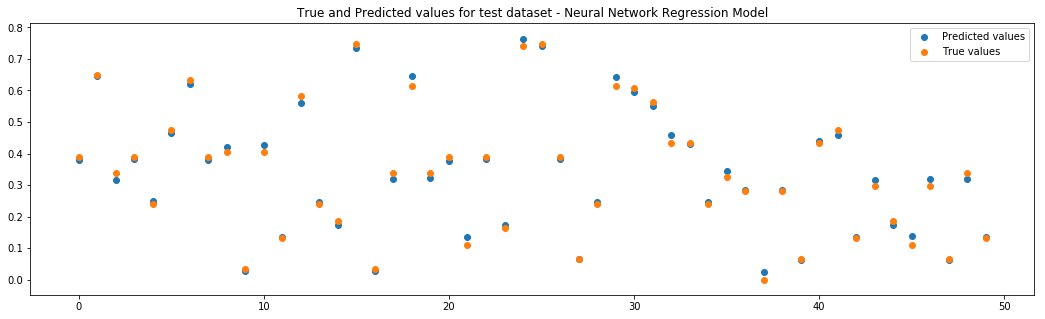

Root Mean Squared Error: [0.01794077]
Mean Absolute Error [0.01332254]
Mean Absolute Percentage Error [6.67430957]


In [38]:
nn_model_metrics = view_metrics(y_test, nn_model_predictions,'Neural Network Regression Model', samples = 50, total_samples=2000)

## Comparing model performances

In [39]:
print("%10s | %7s | %7s | %7s" % ('MODEL', 'RMSE', 'MAE', 'MAPE'))
print('___________________________________________')
for name,metrics in zip(['LIN_REG','RAND_FRST','NN'],[lin_reg_model_metrics, rand_forest_model_metrics, nn_model_metrics]):
    print ("%10s | %.5f | %.5f | %.5f %%" % (name, metrics[0][0], metrics[1][0], metrics[2][0]))
print()
print('Note: Lower values are better')

     MODEL |    RMSE |     MAE |    MAPE
___________________________________________
   LIN_REG | 0.03776 | 0.03093 | 18.68575 %
 RAND_FRST | 0.01660 | 0.01149 | 5.85841 %
        NN | 0.01794 | 0.01332 | 6.67431 %

Note: Lower values are better


## Predicting interest rates

In [40]:
def get_interest_rate(model, features):
    return (model.predict(features))*(max_rate-min_rate) + min_rate

In [41]:
sample = x_test[2:3] # substitute with the input you want to predict the rate for
interest_rate = get_interest_rate(rand_forest_model, sample)
print('Predicted interest rate is:', interest_rate)
print('for the following user profile:')
sample

Predicted interest rate is: [11.48500637]
for the following user profile:


,loan_amnt,term,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,loan_status_Binary
141,0.094118,0.0,0.092174,0.166667,0.205882,0.272727,1.0,0.026464,0.0,0.666667,0.386364,0.565174,0.0,0.0,0.0


### Saving the models

In [42]:
# this cell may take a few seconds to execute depending on model size

# for saving models
import pickle
# import _pickle as cPickle # try this if previous import fails

model_name = 'best_model.model'
pickle.dump(rand_forest_model, open(model_name, 'wb'))

## Saving data for deployment

In [43]:
# order is important
features = ["loan_amnt", "term", "installment", "grade", "sub_grade", "emp_length", "home_ownership", "annual_inc",
            "verification_status", "purpose", "addr_state", "dti", "delinq_2yrs", "inq_last_6mths", "loan_status_Binary"]

In [44]:
prediction_data = [rand_forest_model, df_max, df_min, categories, features]
pickle.dump(prediction_data, open('prediction_data.data', 'wb'))